<a href="https://colab.research.google.com/github/data-aleks/financial_sentiment_stock_analysis/blob/main/financial_sentiment_stock_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Understanding Public Sentiment through Google Search Data and its Application in Financial Analysis**

**Overview**

This project serves as a hands-on exploration of sentiment analysis techniques in Python using publicly available web-scraped data. It demonstrates the complete process from data acquisition and cleaning to feature engineering, analysis, and finally, applying these derived sentiment signals to a real-world, complex domain: forecasting short-term stock price movements.

**Project Structure**
1. Loading Article Data ( Scraped using Python )
2. Loading Stock Data ( Obtained via https://www.marketwatch.com/)
3. Merging Datasets
4. Conducting Sentiment Analysis

**Learning Objective**

The primary goal of this project was to learn and implement various aspects of sentiment analysis using Python, specifically:

*   Acquiring textual data from a public source (Google search results)
*   Processing and extracting sentiment insights from unstructured text.
*   Aggregating and transforming sentiment into quantitative features.
*   Analyzing the relationship between sentiment and external phenomena.

**Data Acquisition And Core Sentiment Analysis**

The project began by web-scraping Google search results related to the target company. This foundational step allowed for practical experience in collecting unstructured textual data. Crucially, raw articles were then processed:



*   **Sentiment Extraction**: Each article's title, description, and full text were analyzed using a Python sentiment analysis library (e.g., VADER, which was used to generate compound_score, title_vader_compound, desc_vader_compound). This involved understanding how to apply NLP techniques to quantify emotional tone.
*    **Weekly Aggregation**: Individual article-level sentiment scores were aggregated to a weekly frequency. This involved groupby operations to calculate key metrics like the num_articles per week (representing attention volume) and the average sentiment scores across titles, descriptions, and full texts. This aggregation was vital for transitioning from granular text data to structured time-series features.



**Sentiment Feature Engineering**

Beyond basic averages, the project focused on engineering more sophisticated sentiment features:



*   **weighted_sentiment**: A key learning point was creating a composite sentiment score by blending different article sentiment components (title, description, full text) with custom weights (e.g., 0.5 for description, 0.3 for full text, 0.2 for title). This demonstrated how to build more robust signals by acknowledging the varying informational value of different text sections.
*   **impact_score**: This feature, calculated by multiplying average full text sentiment by the number of articles, explored how to quantify the 'reach' or 'force' of sentiment, assuming that widespread sentiment has a greater effect.
*   **sentiment_vol**: Computing the rolling standard deviation of average full text sentiment (avg_full_text_compound) showcased how to measure the consistency or instability of public sentiment over time, offering another dimension to sentiment analys
*  **Other financial features** like **log_return**, **rolling_std_5**, and **volume** were also incorporated to provide a comprehensive dataset for the subsequent prediction task.


**Analyzing Sentiment's Relationship with Financial Data:**

This phase focused on interpreting the sentiment features in the context of stock performance:



*   **Visual Exploration**: Plotting weeks with strong positive/negative sentiment directly onto the stock's closing price time series (e.g., Figure: Stock Price with Highlighted Sentiment Weeks) provided an intuitive visual understanding of how market emotions might align with price movements. This was a direct application of the engineered sentiment features.
*   **Quantitative Relationship (Correlation)**: A correlation matrix was built to quantify the linear relationships between the sentiment features and next_return. While weighted_sentiment showed the strongest positive linear correlation (0.31) with the target, this step highlighted that sentiment alone might not be a perfect linear predictor.
*   **Investigating Predictivity (Granger Causality)**: A Granger Causality test was performed on weighted_sentiment against next_return (e.g., Figure: Granger Causality Test: Weighted Sentiment → Next Return). This advanced statistical test helped determine if past sentiment statistically predicts future returns. The test found no statistically significant linear Granger-causal relationship at the tested lags. This important finding demonstrated a critical understanding of the limitations of linear relationships and the nuances of sentiment's influence.



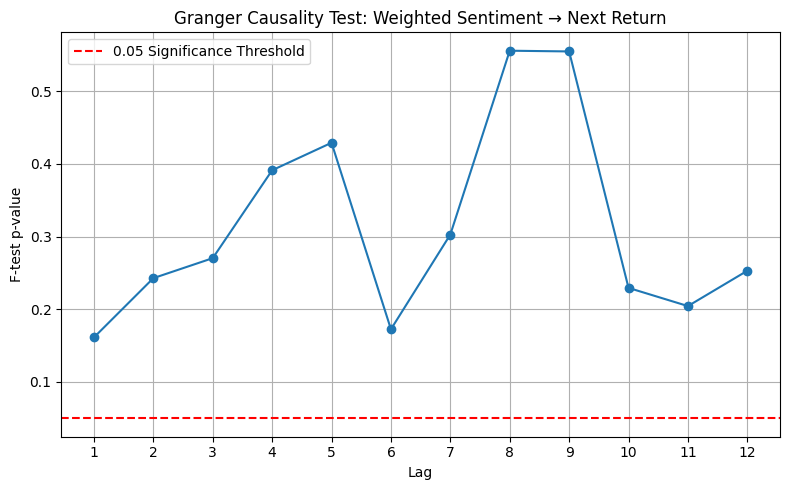

**Applying Sentiment in a Predictive Model:**

As an application of the learned sentiment analysis, an XGBoost Regressor was developed to predict next_return using the engineered features.



*   **Model Performance**: The model achieved an R² of 0.293 and an RMSE of 0.033 (e.g., Figure: Actual vs Predicted: next_return). This outcome, while not indicative of perfect foresight, demonstrated that the sentiment and financial features, when processed by a powerful non-linear model, can capture a meaningful portion of the variance in stock returns.
*   **Learning from Discrepancies**: The project embraced the model's limitations, recognizing that the lack of linear Granger causality, combined with the R² result, illustrates the complexity of financial prediction and the multi-faceted nature of sentiment's impact. It shows that sentiment may contribute through non-linear interactions or by reflecting concurrent market conditions rather than solely as a simple leading indicator.



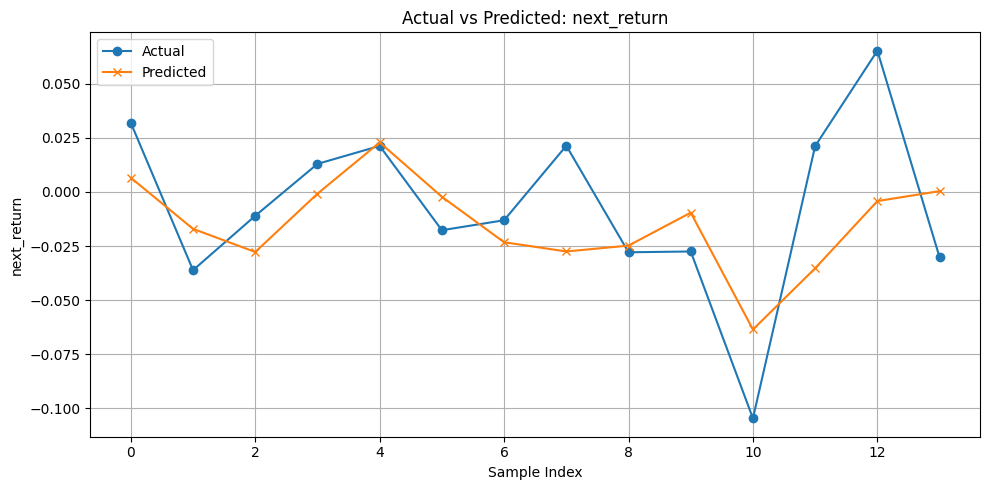

**Project Conclusion**

This project successfully provided a robust learning experience in end-to-end sentiment analysis with Python. From collecting raw text data and converting it into sophisticated quantitative features, to statistically and visually analyzing its relationship with financial outcomes, the project provided hands-on exposure to a comprehensive data science workflow. It demonstrated that while direct linear predictability of stock prices from sentiment is challenging, carefully engineered sentiment features can still contribute valuable signals to powerful machine learning models. This journey highlighted the importance of critical data interpretation, understanding model limitations, and the iterative nature of data science.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import nltk
import re

from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from statsmodels.tsa.stattools import grangercausalitytests
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# 1. **Loading article data**

In this step we load our scraped article data from google searches ( scraping done using python script )

## 1.1 **Read and explore scraped data**

In [2]:
df_pfizer_articles = pd.read_csv('./drive/MyDrive/datasets/pfizer/scraped_articles_data_combined.csv')

Function to parse the text an remove any html elements.

In [3]:
def clean_text(text):
    # Remove HTML
    soup = BeautifulSoup(text, "html.parser")
    text_only = soup.get_text()

    # Remove special characters (keep alphanumeric and basic punctuation)
    text_cleaned = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"]+', '', text_only)

    # Normalize whitespace
    return re.sub(r'\s+', ' ', text_cleaned).strip()


In [4]:
df_pfizer_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487 entries, 0 to 1486
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   keyword      1487 non-null   object
 1   link         1487 non-null   object
 2   title        1487 non-null   object
 3   description  1487 non-null   object
 4   date         1487 non-null   object
 5   full_text    1315 non-null   object
dtypes: object(6)
memory usage: 69.8+ KB


In [5]:
df_pfizer_articles.describe()

,keyword,link,title,description,date,full_text
count,1487,1487,1487,1487,1487,1315
unique,5,1033,982,1168,420,904
top,Pfizer,https://finance.yahoo.com/news/bernstein-reaff...,Pfizer Declares Third-Quarter 2025 Dividend,Investing.com -- Pfizer Inc. (NYSE:PFE) report...,1 month ago,Try unlimited access Only £1 for 4 weeks\n\nTh...
freq,300,4,6,8,215,30


In [6]:
df_pfizer_articles.dropna(subset=['full_text'], inplace=True)

In [7]:
df_pfizer_articles.head()

,keyword,link,title,description,date,full_text
0,Pfizer,https://www.businesswire.com/news/home/2025062...,Pfizer Declares Third-Quarter 2025 Dividend,Pfizer Inc. (NYSE: PFE) today announced that i...,22 hours ago,NEW YORK--(BUSINESS WIRE)--Pfizer Inc. (NYSE: ...
1,Pfizer,https://www.dailymail.co.uk/news/article-14795...,I was a healthy father-of-four until I had the...,"Dean Valentine, from Essex, claims he has spen...",1 day ago,"Approaching his late 50s, Dean Valentine was a..."
2,Pfizer,https://www.chemistryworld.com/careers/the-sta...,The startups that grew out of the Pfizer redun...,"18 months on, three former Pfizer employees ex...",11 hours ago,"18 months on, three former Pfizer employees ex..."
3,Pfizer,https://www.fiercepharma.com/pharma/pfizers-he...,Pfizer's hemophilia drug Hympavzi notches phas...,Successful trial data in a subset of hemophili...,7 hours ago,Subscribe\nPHARMA\nPfizer's hemophilia drug Hy...
4,Pfizer,https://firstwordpharma.com/story/5976358,Pfizer sets up Hympavzi expansion into haemoph...,Already approved in key markets for severe hae...,9 hours ago,RELATED NEWS\nVIEW MORE RELATED NEWS\nRELATED ...


In [8]:
df_pfizer_articles['title'] = df_pfizer_articles['title'].apply(clean_text)
df_pfizer_articles['description'] = df_pfizer_articles['description'].apply(clean_text)
df_pfizer_articles['full_text'] = df_pfizer_articles['full_text'].apply(clean_text)

NameError: name 'BeautifulSoup' is not defined

In [ ]:
df_pfizer_articles['source'] = df_pfizer_articles['link'].str.extract(r'https?://(?:www\.)?([a-zA-Z0-9\-]+)\.')



In [ ]:
df_pfizer_articles.info()

In [ ]:
df_pfizer_articles[df_pfizer_articles.duplicated()]

In [ ]:
df_pfizer_articles = df_pfizer_articles.drop_duplicates()

In [ ]:
df_pfizer_articles.info()

In [ ]:
df_pfizer_articles.dropna(subset=["date"], inplace=True)

In [ ]:
df_pfizer_articles.info()

## 1.2 **Clean up dates**

In [ ]:
def standardize_date(date_str, current_time=None):
    """
    Standardizes a date string into a datetime object.
    Prioritizes pandas.to_datetime for direct date parsing, then handles 'ago' formats.

    Args:
        date_str (str): The date string to standardize.
        current_time (datetime, optional): The reference time for 'ago' calculations.
                                         Defaults to the current system time if None.

    Returns:
        datetime: The standardized datetime object, or pd.NaT if parsing fails.
    """
    if pd.isna(date_str): # Handle NaN or None inputs
        return pd.NaT

    # Ensure current_time is set for 'ago' calculations
    if current_time is None:
        current_time = datetime.now()

    # Crucial: Keep original case for to_datetime attempt
    original_date_str = str(date_str).strip()

    # --- Attempt 1: Use pandas.to_datetime for direct date parsing (most robust for standard formats) ---
    try:
        # Infer format, coerce errors to NaT. dayfirst=True is good for UK formats.
        parsed_dt = pd.to_datetime(original_date_str, errors='coerce', dayfirst=True)
        if pd.notna(parsed_dt):
            return parsed_dt
    except Exception:
        # Fallback if pd.to_datetime itself raises an unexpected error
        pass

    # --- Attempt 2: Handle "X ago" formats (requires string manipulation) ---
    # Convert to lowercase for 'ago' parsing
    lower_date_str = original_date_str.lower()

    if "ago" in lower_date_str:
        num_match = re.search(r'\d+', lower_date_str)
        num = int(num_match.group()) if num_match else 0

        if "minute" in lower_date_str:
            return current_time - timedelta(minutes=num)
        elif "hour" in lower_date_str:
            return current_time - timedelta(hours=num)
        elif "day" in lower_date_str:
            return current_time - timedelta(days=num)
        elif "week" in lower_date_str:
            return current_time - timedelta(weeks=num)
        elif "month" in lower_date_str:
            return current_time - timedelta(days=num * 30) # Approximate
        elif "year" in lower_date_str:
            return current_time - timedelta(days=num * 365) # Approximate
        else:
            return pd.NaT # "ago" but unknown unit

    # --- Attempt 3: Handle cases where the year might be missing (e.g., "14 Apr") ---
    # This comes after pd.to_datetime because pd.to_datetime might not infer this without a year
    # Re-apply lowercasing for consistent month abbreviation matching
    match = re.match(r'(\d+)\s+([a-zA-Z]+)$', lower_date_str)
    if match:
        day = int(match.group(1))
        month_str = match.group(2)
        try:
            # Try parsing with current year (e.g., "10 Mar" -> "10 Mar 2025")
            # Using pd.to_datetime here again for robustness
            temp_date_str_with_year = f"{day} {month_str} {current_time.year}"
            return pd.to_datetime(temp_date_str_with_year, errors='coerce', dayfirst=True)
        except Exception:
            return pd.NaT

    # If none of the above formats match, return NaT
    return pd.NaT

# --- Helper function for 'Today', 'Yesterday' etc. ---
def handle_relative_terms(date_str, current_time):
    # Ensure current_time is a datetime object
    if not isinstance(current_time, datetime):
        raise TypeError("current_time must be a datetime object.")

    date_str_lower = str(date_str).strip().lower()
    if date_str_lower == 'today':
        return current_time.replace(hour=0, minute=0, second=0, microsecond=0) # Start of today
    elif date_str_lower == 'yesterday':
        return (current_time - timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
    # Add other relative terms here if needed (e.g., 'tomorrow', 'next week')
    return date_str # Return original string if not a relative term handled here


In [ ]:
reference_time = datetime(2025, 6, 25, 12, 57, 59)

In [ ]:
df_pfizer_articles['processed_date'] = df_pfizer_articles['date'].apply(lambda x: handle_relative_terms(x, reference_time))

In [ ]:
df_pfizer_articles['standardized_date'] = df_pfizer_articles['processed_date'].apply(lambda x: standardize_date(x, current_time=reference_time))


In [ ]:
df_pfizer_articles.info()

In [ ]:
df_pfizer_articles.head()

In [ ]:
df_pfizer_articles['date'] = df_pfizer_articles['standardized_date']

In [ ]:
df_pfizer_articles = df_pfizer_articles.drop(columns={'processed_date', 'standardized_date'})

In [ ]:
df_pfizer_articles.info()

## 1.3 **Applying Vader**

In this step we will add our sentiment output values from Vader to our dataset

In [ ]:
# Create a snetiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
# Function to return sentiment scores based on text provided.
def get_vader_scores(text):
    if pd.isna(text) or not isinstance(text, str):
        return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0} # Return default scores for non-string/NaN
    return analyzer.polarity_scores(text)


In [ ]:
# Function to generate scores for large text ( our full text data), in this function we split initial text in to chuncks of 250 and generate compound score
def apply_vader_to_chunks(df, text_column, chunk_size=250):
    def get_chunks(text, size):
        words = text.split()
        return [' '.join(words[i:i+size]) for i in range(0, len(words), size)]

    def get_compound_score(text):
        if pd.isna(text) or not isinstance(text, str):
            return None
        chunks = get_chunks(text, chunk_size)
        scores = [analyzer.polarity_scores(chunk)['compound'] for chunk in chunks]
        return sum(scores) / len(scores) if scores else 0.0

    df['compound_score'] = df[text_column].apply(get_compound_score)
    return df



In [ ]:
# This function will label our data based on the vader score output.
def get_sentiment_label(compound_score, threshold=0.05):
    if compound_score >= threshold:
        return 'Positive'
    elif compound_score <= -threshold:
        return 'Negative'
    else:
        return 'Neutral'

In [ ]:
# Apply vader to full text column
df_pfizer_articles = apply_vader_to_chunks(df_pfizer_articles, 'full_text')

In [ ]:
# Apply vader to title
title_sentiment_scores = df_pfizer_articles['title'].apply(get_vader_scores)
df_pfizer_articles = pd.concat([
    df_pfizer_articles,
    pd.DataFrame(title_sentiment_scores.tolist(), index=df_pfizer_articles.index).add_prefix('title_vader_')
], axis=1)


In [ ]:
# Apply vader to descruotuib
description_sentiment_scores = df_pfizer_articles['description'].apply(get_vader_scores)
df_pfizer_articles = pd.concat([
    df_pfizer_articles,
    pd.DataFrame(description_sentiment_scores.tolist(), index=df_pfizer_articles.index).add_prefix('desc_vader_')
], axis=1)

In [ ]:
# Create label columns to assign Positive, Negative or Neutral to our data values
df_pfizer_articles['title_sentiment_label'] = df_pfizer_articles['title_vader_compound'].apply(get_sentiment_label)
df_pfizer_articles['desc_sentiment_label'] = df_pfizer_articles['desc_vader_compound'].apply(get_sentiment_label)
df_pfizer_articles['full_text_sentiment_label'] = df_pfizer_articles['compound_score'].apply(get_sentiment_label)
df_pfizer_articles['date'] = pd.to_datetime(df_pfizer_articles['date'])

In [ ]:
# Let's see how our dataset looks like now
df_pfizer_articles.info()

In [ ]:
# Lets count our positive negative and neutral values.
sentiment_counts = df_pfizer_articles['full_text_sentiment_label'].value_counts()

print(sentiment_counts)
print("\n")

## 1.4 **Grouping data**

In this step we will group our articles data by date.

In [ ]:
# Group our articles dataset by date use mean for vader scores.
grouped_df = df_pfizer_articles.groupby('date').agg(
    num_articles=('date', 'size'),
    avg_title_compound=('title_vader_compound', 'mean'),
    avg_desc_compound=('desc_vader_compound', 'mean'),
    avg_full_text_compound=('compound_score', 'mean')
).reset_index()


In [ ]:
# Get sentiment labels for our grouped data
grouped_df['avg_title_sentiment'] = grouped_df['avg_title_compound'].apply(get_sentiment_label)
grouped_df['avg_desc_sentiment'] = grouped_df['avg_desc_compound'].apply(get_sentiment_label)
grouped_df['avg_full_text_sentiment'] = grouped_df['avg_full_text_compound'].apply(get_sentiment_label)

In [ ]:
# Ensure dates are consistently formatted
grouped_df['processed_date'] = grouped_df['date'].apply(lambda x: handle_relative_terms(x, reference_time))
grouped_df['standardized_date'] = grouped_df['processed_date'].apply(lambda x: standardize_date(x, current_time=reference_time))

In [ ]:
# Replace date column with values from our standardized date
grouped_df['date'] = grouped_df['standardized_date']
grouped_df.drop(columns={'processed_date','standardized_date'}, inplace=True)

In [ ]:
grouped_df.tail()

In [ ]:
grouped_df.info()

# 2. **Loading stock data**

In this step we will load our stock price data.

In [ ]:
# Our stock price data is stored in 3 separate files ( This is due to the limitations on free download on the website https://www.marketwatch.com/ )
stock_price_data = ['./drive/MyDrive/datasets/pfizer/2022.csv','./drive/MyDrive/datasets/pfizer/2023.csv','./drive/MyDrive/datasets/pfizer/2024.csv']

In [ ]:
# Combined our three files in to a singular dataframe
df_stock_data = pd.concat([pd.read_csv(file) for file in stock_price_data], ignore_index=True)

In [ ]:
# Check how our dataset looks like
df_stock_data.info()

In [ ]:
# Convert date to the date type
df_stock_data['Date'] = pd.to_datetime(df_stock_data['Date'])

In [ ]:
# Sort values by date
df_stock_data = df_stock_data.sort_values(by='Date')

In [ ]:
# Resulting data
df_stock_data.tail(10)

In [ ]:
# Quci visualisation for time series data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_stock_data['Date'], df_stock_data['Close'], label='Stock Close Price', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Stock Price Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. **Merge Datasets**

In this step we will merge our two datasets together to get a single dataset to work with.

In [ ]:
# Lets ensure our date is date format
grouped_df['date'] = pd.to_datetime(grouped_df['date'])


In [ ]:
# Create a new dataset by merging our grouped_df and df_stock_data on Date
data_merged_df = pd.merge(grouped_df, df_stock_data, right_on="Date", left_on="date", how='inner')

In [ ]:
# Lets remove any unnecessary columns
data_merged_df = data_merged_df[['Date', 'num_articles', 'avg_title_compound', 'avg_desc_compound','avg_full_text_compound','avg_full_text_sentiment', 'Close', 'Volume']]

In [ ]:
# Sort by date
data_merged_df = data_merged_df.sort_values(by='Date')

In [ ]:
# Volume data is stored as a string separated by , lets change our volume data in to a float by replacing our ',' with empty space and casting astype float
data_merged_df['Volume'] = data_merged_df['Volume'].str.replace(',', '').astype(float)

In [ ]:
# Make our columns lower case
data_merged_df.columns = [col.lower() for col in data_merged_df.columns]

In [ ]:
# Rename close column to something more readable like close_price
data_merged_df.rename(columns={
    'close': 'close_price'
}, inplace=True)

In [ ]:
# Our resulting dataset
data_merged_df.info()

# 4. **Sentiment Analysis**.

## 4.1 **Grouping In to Weekly Data.**

Group data in to weeks.

In [ ]:
# Group our data in to weekly segments
weekly_df = data_merged_df.groupby(pd.Grouper(key='date', freq='W')).agg({
    'num_articles': 'sum',
    'avg_title_compound': 'mean',
    'avg_desc_compound': 'mean',
    'avg_full_text_compound': 'mean',
    'volume': 'mean',
    'close_price': 'mean'
}).reset_index()


In [ ]:
# Remove any records without close_price
weekly_df.dropna(subset=['close_price'], inplace=True)

In [ ]:
# Apply overall sentiment label
weekly_df['sentiment_label'] = weekly_df['avg_full_text_compound'].apply(get_sentiment_label)

In [ ]:
# Sort data by date
weekly_df = weekly_df.sort_values(by = "date")

In [ ]:
weekly_df.info()

## 4.2 **Adding New Features to Our Weekly Dataset.**

In [ ]:
# 1️⃣ --- Calculate Weekly Log Returns ---
# Get the closing price from the previous week (lagged by 1 period)
weekly_df['close_lag1'] = weekly_df['close_price'].shift(1)

# Compute the natural logarithm of the ratio of current close price to last week's close price.
# Log returns are preferred in financial modeling for their additive properties and
# better statistical behavior compared to simple percentage changes.
weekly_df['log_return'] = np.log(weekly_df['close_price'] / weekly_df['close_lag1'])

# 2️⃣ --- Create Sentiment-Based Features ---
# Calculate an 'impact score' for sentiment by multiplying the average full text compound sentiment
# by the number of articles. This aims to capture the intensity of emotion weighted by volume.
weekly_df['impact_score'] = weekly_df['avg_full_text_compound'] * weekly_df['num_articles']

# Determine the volatility (standard deviation) of the average full text sentiment
# over a 12-week rolling window. This indicates how unstable or consistent sentiment has been.
weekly_df['sentiment_vol'] = weekly_df['avg_full_text_compound'].rolling(12).std()

# 3️⃣ --- Generate Volatility-Based Features (and a potential future target) ---
# Calculate the rolling 12-week standard deviation of log returns.
# This serves as a measure of historical price volatility for the current period.
weekly_df['rolling_std_5'] = weekly_df['log_return'].rolling(window=12).std()

# Create a lagged version of the rolling volatility.
# Shifting by -1 means this column will contain the volatility for the *next* period.
# This variable could serve as a target for predicting future volatility,
# or as a feature if the model is designed to look ahead (though typically
# future information is avoided in features to prevent data leakage for prediction tasks).
weekly_df['rolling_std_5_lag1'] = weekly_df['rolling_std_5'].shift(-1)

# 4️⃣ --- Blend Multiple Sentiment Scores into a Weighted Score ---
# Create a composite 'weighted_sentiment' by combining sentiment scores from different
# parts of an article (description, full text, title) with custom weights.
# The weights are chosen based on the perceived richness/impact of each text section:
# - Description (0.5): Often concise and highlights key sentiment.
# - Full Text (0.3): Provides broader context, but can be diluted.
# - Title (0.2): Short but can be very impactful or clickbait-driven.
weekly_df['weighted_sentiment'] = (
    0.5 * weekly_df['avg_desc_compound'] +   # Highest weight for description sentiment
    0.3 * weekly_df['avg_full_text_compound'] +  # Medium weight for full text sentiment
    0.2 * weekly_df['avg_title_compound']    # Lowest weight for title sentiment
)

# Calculate the simple percentage change in close price for the current period.
weekly_df['return'] = weekly_df['close_price'].pct_change()

# Define the primary target variable: the simple percentage change in close price
# for the *next* period (shifted backwards by 1 to align with current features).
weekly_df['next_return'] = weekly_df['close_price'].pct_change().shift(-1)

## 4.3 **Exploring Negative and Positive Sentiment Using Closing Price Time Series**

In this step we will simply visualise negative and positive weeks on our price chart.

In [ ]:
# 🧼 1. Filter the dataset by sentiment labels
# Separate weeks with negative sentiment
negative_df = weekly_df[weekly_df['sentiment_label'] == 'Negative'].copy()

# Separate weeks with positive sentiment
positive_df = weekly_df[weekly_df['sentiment_label'] == 'Positive'].copy()

# 📊 2. Begin plotting the stock price and sentiment annotations
plt.figure(figsize=(12, 6))  # Create a new figure with a wide format for clarity

# Plot the full stock price time series in gray as the baseline
plt.plot(
    weekly_df['date'],
    weekly_df['close_price'],
    label='Stock Price',
    color='gray',
    linewidth=1.5
)

# 🔴 Overlay points where sentiment was negative — red dots on those weeks
plt.scatter(
    negative_df['date'],
    negative_df['close_price'],
    color='red',
    label='Negative Sentiment',
    zorder=5  # Ensure scatter points appear on top
)

# 🟢 Overlay points where sentiment was positive — green dots for contrast
plt.scatter(
    positive_df['date'],
    positive_df['close_price'],
    color='green',
    label='Positive Sentiment',
    zorder=5
)

# 🧱 Add plot styling and context
plt.grid(visible=True)                             # Add a grid for easier interpretation
plt.title('Stock Price with Highlighted Sentiment Weeks')  # Set the plot title
plt.xlabel('Date')                                 # Label the x-axis
plt.ylabel('Close Price')                          # Label the y-axis
plt.legend()                                       # Add a legend to explain the colors
plt.tight_layout()                                 # Prevent label and element overlap
plt.show()                                         # Render the final plot

## 4.4 **Build a Features Correlation Matrix.**

In this step we will create a simple correlation matrix to see which of our features correlate together.

In [ ]:
#Calculate correlation for a specific subset of columns
features = [
    'weighted_sentiment', 'impact_score', 'sentiment_vol',
    'rolling_std_5', 'volume', 'log_return', 'next_return' # Add other relevant features/targets
]
selected_df = weekly_df[features]
correlation_matrix_subset = selected_df.corr()
print(correlation_matrix_subset)

## 4.5 **Granger Casuality Test**

In this step we will run the granger casuality test on weighted sentiment to establish whether weighted sentiment has predictive qualities when it comes to next_return (the simple percentage change in close price) .

In [ ]:
# 🧼 1. Prepare the data
# Select only the sentiment signal and stock closing price, drop rows with missing values
df_gc = weekly_df[['weighted_sentiment', 'next_return']].dropna()

# ⚗️ 2. Define maximum lag to test for causal influence
max_lag = 12

# 🧪 3. Run Granger causality test up to max_lag
# This tests whether past values of sentiment can help predict future Close prices
test_result = grangercausalitytests(df_gc, maxlag=max_lag, verbose=False)

# 📈 4. Extract F-test p-values for each lag
# We round for readability and store them in a list
p_values = [round(test_result[i + 1][0]['ssr_ftest'][1], 4) for i in range(max_lag)]

# 📊 5. Plot p-values across different lags to visualize significance
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_lag + 1), p_values, marker='o', linestyle='-')

# 🔺 Add a red dashed line at p = 0.05 to mark the statistical significance threshold
plt.axhline(y=0.05, color='red', linestyle='--', label='0.05 Significance Threshold')

# 🏷 Annotate the plot
plt.title('Granger Causality Test: Weighted Sentiment → Next Return')
plt.xlabel('Lag')
plt.ylabel('F-test p-value')
plt.xticks(range(1, max_lag + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4.6 **XGBoost Model.**

In this step we will utilise XGBoost Model on our previously created features

In [ ]:
features = [
     'weighted_sentiment', 'impact_score', 'sentiment_vol',  'rolling_std_5', 'volume'
]
target = 'next_return'

df_model = weekly_df.dropna(subset=features + [target])
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model = XGBRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

print("R²:", r2_score(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))

### 4.7.1 **Visualise XGBoost Results.**

Let's visualise how well does our model performs.

In [ ]:
# 📐 Create a new figure window with a defined size (10 inches wide, 5 inches tall)
plt.figure(figsize=(10, 5))

# 📈 Plot the actual values (ground truth) using circles at each point
plt.plot(y_test.values, label='Actual', marker='o')

# 🔮 Plot the predicted values using x-marks for visual contrast
plt.plot(preds, label='Predicted', marker='x')

# 🏷 Add a title showing what we're comparing
plt.title('Actual vs Predicted: ' + target)

# 🧭 Label the x-axis (each point represents a week or sample)
plt.xlabel('Sample Index')

# 📊 Label the y-axis with the name of the target variable
plt.ylabel(target)

# 🧾 Add a legend so we know which line is which
plt.legend()

# 🧱 Add a grid to make the chart easier to read
plt.grid(True)

# 🧼 Ensure everything fits neatly and labels don't overlap
plt.tight_layout()

# 👁 Display the plot
plt.show()